# <center><b>mdapy</b>: Molecular dynamics simulation analysis with Python</center>

<center><img src="https://img.pterclub.com/images/2023/01/06/logo.png" alt="logo.png" border="0" width="500"/></center>

#### <center> <b>Author</b>：Yong-Chao Wu </center>
#### <center> <b>Supervisor</b>: Jian-Li Shao</center>
#### <center> <b>Date</b>: 2023/09/23</center>
- Wu, Y. C., & Shao, J. L. (2023). mdapy: A flexible and efficient analysis software for molecular dynamics simulations. Computer Physics Communications, 290, 108764. https://doi.org/10.1016/j.cpc.2023.108764

# <b>Tutorial for Beginners</b>

## <b>1. 适用范围</b>
- 主要面向固体材料的模拟，特别是金属/合金体系
- 适合于单一Frame的系统状态分析，而不是一个轨迹中不同Frame间的关联分析
- 直接支持LAMMPS中的dump和data文件格式
- 仅支持三维构型

## <b>2. 安装</b>

- conda create -n mda
- conda activate mda
- pip install mdapy -U

## <b>3. 使用流程</b>

<img src="https://img.pterclub.com/images/2023/09/22/workflow.png" alt="workflow.png" border="0" width="800"/>

- 导入需要的库

In [1]:
import mdapy as mp
import numpy as np
import matplotlib.pyplot as plt
mp.init()

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.12
[Taichi] Starting on arch=x64


- 查看mdapy版本

In [2]:
mp.__version__

'0.9.0'

## <b> 4. System Class </b>

mdapy中一个核心的结构是*System*类，这个类由原子的Position, Box和Boundary组成
- 生成System类的第一种方式，直接读取一个Dump/Data文件

In [3]:
system = mp.System('./frame/CoCuFeNiPd.dump')

- 查看system实例包含的信息

In [4]:
system

Filename: ./frame/CoCuFeNiPd.dump
Atom Number: 8788
Simulation Box:
[[47.36159615  0.          0.        ]
 [ 0.         47.46541884  0.        ]
 [ 0.          0.         47.46849764]
 [-1.18079807 -1.23270942 -1.23424882]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
   id  type         x         y         z
0   1     2  0.006118 -0.310917 -0.345241
1   2     4  1.901900 -0.292456  1.484880
2   3     3 -0.015641  1.584320  1.431290
3   4     5  1.862370  1.511170 -0.372278
4   5     5  3.792570 -0.331891 -0.375830

- 查看Box信息
1. mdapy中的盒子是一个(4x3)的2维数组，前三行代表盒子的三个基向量，最后一行是盒子的原点
2. 盒子采用LAMMPS的规则，所以box[0, 1]==box[0, 2]==box[1, 2]==0
3. 对于正交盒子，为了和之前版本的兼容性，mdapy也支持(3x2)的盒子，第一列代表[xlo, ylo, zlo],第二列代表[xhi, yhi, zhi]

In [5]:
system.box

array([[47.36159615,  0.        ,  0.        ],
       [ 0.        , 47.46541884,  0.        ],
       [ 0.        ,  0.        , 47.46849764],
       [-1.18079807, -1.23270942, -1.23424882]])

- 查看原子Position信息
- (Nx3)的2维数组,分别代表x, y, z坐标

In [6]:
system.pos

array([[ 6.11791e-03, -3.10917e-01, -3.45241e-01],
       [ 1.90190e+00, -2.92456e-01,  1.48488e+00],
       [-1.56413e-02,  1.58432e+00,  1.43129e+00],
       ...,
       [ 4.53771e+01,  4.37577e+01,  4.52727e+01],
       [ 4.34552e+01,  4.54854e+01,  4.52825e+01],
       [ 4.53919e+01,  4.54009e+01,  4.34999e+01]])

- 查看边界Boundary信息
- 是一个包含三个数字的列表，其中1代表周期性边界，0代表自由边界

In [7]:
system.boundary

[1, 1, 1]

- 查看所有Particle相关的数据
- 存储为DataFrame的格式

In [8]:
system.data

,id,type,x,y,z
0,1,2,0.006118,-0.310917,-0.345241
1,2,4,1.901900,-0.292456,1.484880
2,3,3,-0.015641,1.584320,1.431290
3,4,5,1.862370,1.511170,-0.372278
4,5,5,3.792570,-0.331891,-0.375830
...,...,...,...,...,...
8783,8784,3,41.559500,45.481000,43.499600
8784,8785,4,43.457500,43.737100,43.608300
8785,8786,4,45.377100,43.757700,45.272700
8786,8787,4,43.455200,45.485400,45.282500


## <b> 5. Neighbor information </b>

### <b> 5.1 截断半径内的邻域 </b>
- 使用元胞链表算法建立邻域

In [9]:
system.build_neighbor(rc=5., max_neigh=60)

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


- 查看原子的邻域列表
1. 是一个(N, max_neigh)的2维数组，每一行对应该原子的邻域内原子索引
2. max_neigh代表最大邻域原子数目，可以手动指定，也可以自动生成
3. 手动指定可以节约内存，提高计算速度

In [10]:
system.verlet_list

array([[8787, 8786, 8785, ...,   -1,   -1,   -1],
       [8683, 8678, 7785, ...,   -1,   -1,   -1],
       [8683, 8678, 7890, ...,   -1,   -1,   -1],
       ...,
       [8787, 8786, 8784, ...,   -1,   -1,   -1],
       [8787, 8785, 8784, ...,   -1,   -1,   -1],
       [8786, 8785, 8784, ...,   -1,   -1,   -1]])

- 查看原子的邻域距离列表
- 与verlet_list相对应的欧式距离，考虑了周期性边界

In [11]:
system.distance_list

array([[4.48415851, 4.63487321, 4.35033004, ..., 6.        , 6.        ,
        6.        ],
       [4.46090018, 4.58191893, 4.52604475, ..., 6.        , 6.        ,
        6.        ],
       [4.31507754, 4.44738973, 4.59567837, ..., 6.        , 6.        ,
        6.        ],
       ...,
       [2.41725984, 2.5843264 , 2.54077073, ..., 6.        , 6.        ,
        6.        ],
       [2.63355461, 2.5843264 , 2.4206412 , ..., 6.        , 6.        ,
        6.        ],
       [2.63355461, 2.41725984, 2.55379803, ..., 6.        , 6.        ,
        6.        ]])

- 查看原子的邻域原子数目

In [12]:
system.neighbor_number

array([43, 44, 42, ..., 44, 44, 43])

- 获取0号原子的近邻列表

In [13]:
system.verlet_list[0][system.verlet_list[0]>-1]

array([8787, 8786, 8785, 8683, 8678, 8677, 8676, 7890, 7887, 7886, 7885,
       7785, 7782, 7779, 7778, 7777, 7776, 1012, 1010, 1009, 1008,  902,
        901,  899,  897,  896,  895,  894,  115,  113,  111,  110,  109,
        108,   10,    9,    7,    6,    5,    4,    3,    2,    1])

- 对应的距离

In [14]:
system.distance_list[0][system.distance_list[0]<=system.rc]

array([4.48415851, 4.63487321, 4.35033004, 4.32684219, 2.57315649,
       4.56321812, 4.28528359, 4.59095276, 4.66010003, 4.75302553,
       2.75477768, 4.39168451, 4.61796939, 2.72325674, 4.72094208,
       2.60048836, 3.89905069, 4.59982507, 4.55429545, 2.58034816,
       4.3158718 , 4.39625655, 4.94515661, 4.54723002, 2.57907233,
       2.51207599, 4.33703698, 3.40006632, 4.52692755, 4.59187976,
       4.58003255, 2.63799722, 2.64905416, 3.73204205, 4.42655427,
       3.47691914, 4.43249288, 3.67048701, 4.59684361, 3.78663373,
       2.60123122, 2.59777966, 2.63508509])

- 计算距离来验证

In [15]:
system.atom_distance(0, 8787)

4.484158107630933

### <b> 5.2 固定数目的最近邻查找 </b>
- 使用Kdtree来建立最近邻列表

In [16]:
kdt = mp.NearestNeighbor(system.pos, system.box, system.boundary)

In [17]:
distance_list, verlet_list = kdt.query_nearest_neighbors(12)

- 查看最近邻信息

In [18]:
verlet_list[0]

array([ 896, 8678,  897, 1009,    2, 7777,    3,    1,  110,  109, 7779,
       7885], dtype=int64)

In [19]:
distance_list[0]

array([2.51207536, 2.57315662, 2.5790717 , 2.58034708, 2.59777966,
       2.60048908, 2.60123122, 2.63508509, 2.63799678, 2.64905374,
       2.72325745, 2.75477797])

## <b> 6. 后处理分析 </b>

#### 6.1 计算径向分布函数

In [20]:
system.cal_pair_distribution()

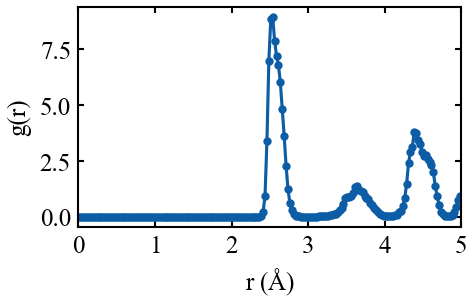

In [21]:
fig, ax = system.PairDistribution.plot()

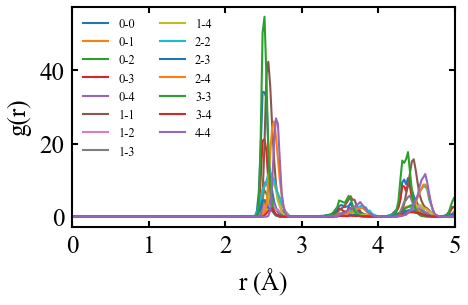

In [22]:
fig, ax = system.PairDistribution.plot_partial()

#### 6.2 计算WCP参数

In [23]:
system.cal_warren_cowley_parameter()

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


In [24]:
system.WarrenCowleyParameter.WCP

array([[-1.39078011,  0.63941399,  0.39269725, -0.30498922,  0.66252684],
       [ 0.63941399, -1.93830149,  0.58034431,  0.51486949,  0.20332652],
       [ 0.3929276 ,  0.58050349, -0.56415998,  0.63267377, -1.04016883],
       [-0.30492733,  0.51489249,  0.63255182, -1.69477812,  0.85080842],
       [ 0.66254282,  0.20336424, -1.04084631,  0.8508084 , -0.67471711]])

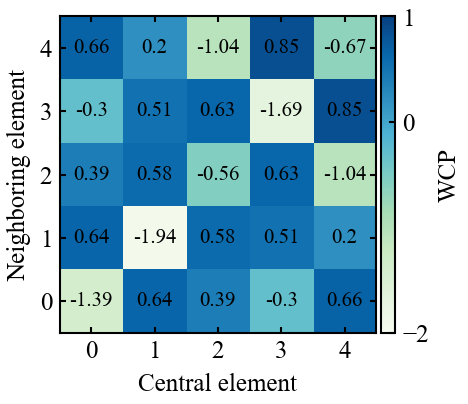

In [25]:
fig, ax = system.WarrenCowleyParameter.plot()

#### 6.3 PTM结构分析

In [26]:
system.cal_polyhedral_template_matching()

#### 6.4 计算中心对称参数

In [27]:
system.cal_centro_symmetry_parameter()

#### 6.5 计算构型熵

In [28]:
system.cal_atomic_entropy(rc=3.6*1.4, compute_average=True, average_rc=3.6*0.9)

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


#### 6.6 计算Voronoi体积

In [29]:
system.cal_voronoi_volume()

#### 查看计算结果

In [30]:
system.data.head()

,id,type,x,y,z,structure_types,csp,atomic_entropy,ave_atomic_entropy,voronoi_volume,voronoi_number,cavity_radius
0,1,2,0.006118,-0.310917,-0.345241,1,0.100696,-5.997982,-6.469181,12.681010,15,3.675684
1,2,4,1.901900,-0.292456,1.484880,1,0.139543,-6.640986,-6.677864,12.012947,14,3.581766
2,3,3,-0.015641,1.584320,1.431290,1,0.094929,-6.821842,-6.666716,12.197214,12,3.674408
3,4,5,1.862370,1.511170,-0.372278,1,0.072999,-6.958320,-6.940528,12.900968,15,3.713117
4,5,5,3.792570,-0.331891,-0.375830,1,0.046358,-6.679067,-6.846047,12.400861,14,3.645415


#### 保存结果到新的dump/data文件

In [31]:
system.write_dump()

#### 6.7 使用Bond order判断是solid还是liquid
- 这里重新读取一个固液共存的dump文件

In [32]:
system = mp.System('frame/solidliquid.dump') # 钼（Molybdenum） 2896 K

In [33]:
system.cal_steinhardt_bond_orientation(solidliquid=True)

#### 6.8 计算原子平均温度

In [34]:
system.cal_atomic_temperature(system.data['mass'].unique())

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


In [35]:
print(f"Average temperature is {system.data['atomic_temp'].mean()} K")

Average temperature is 2672.12262088679 K


In [36]:
system.data.head()

,id,type,mass,x,y,z,vx,vy,vz,ql6,solidliquid,atomic_temp
0,7913,1,95.94,2.641080,3.215200,1.741970,2.900960,1.728750,-1.77975,0.338703,0,2234.237250
1,4098,1,95.94,-0.091857,0.465800,0.936675,-0.166803,0.959803,3.70312,0.503473,0,2610.685635
2,4414,1,95.94,51.307600,2.937420,2.124840,4.506050,-1.069240,-1.41931,0.411614,0,2192.303592
3,4,1,95.94,3.577730,-0.024408,2.310720,-6.047090,5.234510,9.18538,0.304366,0,2351.477280
4,37,1,95.94,45.219000,19.565400,-0.241386,-5.203060,3.796940,-2.15249,0.567507,0,2911.470647


In [37]:
system.write_dump()

#### 6.9 识别FCC基体中的ISF,ESF,TW, HCP
- 这里读取一个包含多种缺陷的dump文件

In [38]:
system = mp.System('frame/ISF.dump')

In [39]:
system.cal_identify_SFs_TBs()

In [40]:
system.write_dump()

#### 对于斜盒子体系依然适用
- 这里读取一个HCP的Ti体系

In [41]:
Ti = mp.System('./frame/Ti.data')

In [42]:
Ti

Filename: ./frame/Ti.data
Atom Number: 2
Simulation Box:
[[ 2.93573192  0.          0.        ]
 [-1.46786596  2.54241842  0.        ]
 [ 0.          0.          4.64085615]
 [ 0.          0.          0.        ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
   id  type             x         y         z
0   1     1 -1.467866e-08  1.694946  1.160214
1   2     1  1.467866e+00  0.847473  3.480642

In [43]:
Ti.cal_common_neighbor_analysis(rc=2.9357*1.207)

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


In [44]:
Ti.cal_centro_symmetry_parameter()

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


In [45]:
Ti.data

,id,type,x,y,z,cna,csp
0,1,1,-1.467866e-08,1.694946,1.160214,2,8.618522
1,2,1,1.467866e+00,0.847473,3.480642,2,8.618522


In [46]:
Ti.write_dump()

## <b> 7. 建立初始模型 </b>

#### 7.1 建立简单模型 FCC, BCC, HCP, Graphene

In [47]:
fcc = mp.LatticeMaker(3.615, 'FCC', 10, 10, 10)
fcc.compute()

In [48]:
fcc.box

array([[36.15,  0.  ,  0.  ],
       [ 0.  , 36.15,  0.  ],
       [ 0.  ,  0.  , 36.15],
       [ 0.  ,  0.  ,  0.  ]])

In [49]:
fcc.pos

array([[ 0.    ,  0.    ,  0.    ],
       [ 1.8075,  1.8075,  0.    ],
       [ 1.8075,  0.    ,  1.8075],
       ...,
       [34.3425, 34.3425, 32.535 ],
       [34.3425, 32.535 , 34.3425],
       [32.535 , 34.3425, 34.3425]])

保存为data/dump文件

In [50]:
fcc.write_data(output_name='./frame/fcc.data')

- 测试一下大体系的计算效率
- 生成400w原子体系

In [51]:
repli = mp.Replicate(fcc.pos, fcc.box, 10, 10, 10)
repli.compute()

- 建立0.5nm邻域

In [52]:
%%time
neigh = mp.Neighbor(repli.pos, repli.box, 5., max_neigh=50)
neigh.compute()

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


CPU times: total: 24.3 s
Wall time: 2.81 s


- 手动排序获取最近邻

In [53]:
%%time
neigh.sort_verlet_by_distance(12)

CPU times: total: 12.6 s
Wall time: 349 ms


In [54]:
neigh.verlet_list[0][:12]

array([      3,       2,       1, 3603602, 3603601,  360363,  360361,
         36039,   36038, 3639638,  396399, 3963961])

In [55]:
neigh.distance_list[0][:12]

array([2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101])

- 搜索12个最近邻

In [56]:
%%time
kdt = mp.NearestNeighbor(repli.pos, repli.box)
dis, verlet = kdt.query_nearest_neighbors(12)

CPU times: total: 44.5 s
Wall time: 3.57 s


In [57]:
dis[0]

array([2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101, 2.55619101, 2.55619101, 2.55619101,
       2.55619101, 2.55619101])

In [58]:
verlet_list[0]

array([ 896, 8678,  897, 1009,    2, 7777,    3,    1,  110,  109, 7779,
       7885], dtype=int64)

#### 使用Position和Box建立System

In [59]:
newsystem = mp.System(pos=fcc.pos, box=fcc.box)

In [60]:
newsystem

Filename: None
Atom Number: 4000
Simulation Box:
[[36.15  0.    0.  ]
 [ 0.   36.15  0.  ]
 [ 0.    0.   36.15]
 [ 0.    0.    0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
    id  type       x       y       z
0  1.0   1.0  0.0000  0.0000  0.0000
1  2.0   1.0  1.8075  1.8075  0.0000
2  3.0   1.0  1.8075  0.0000  1.8075
3  4.0   1.0  0.0000  1.8075  1.8075
4  5.0   1.0  0.0000  0.0000  3.6150

#### 扩展System

In [61]:
newsystem.replicate(3, 3, 3)

In [62]:
newsystem

Filename: None
Atom Number: 108000
Simulation Box:
[[108.45   0.     0.  ]
 [  0.   108.45   0.  ]
 [  0.     0.   108.45]
 [  0.     0.     0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
   id  type       x       y       z
0   1   1.0  0.0000  0.0000  0.0000
1   2   1.0  1.8075  1.8075  0.0000
2   3   1.0  1.8075  0.0000  1.8075
3   4   1.0  0.0000  1.8075  1.8075
4   5   1.0  0.0000  0.0000  3.6150

#### 选择局部区域建立System

In [63]:
subsystem = newsystem.select(newsystem.data[newsystem.data['x']>30])

In [64]:
subsystem

Filename: None
Atom Number: 77400
Simulation Box:
[[108.45   0.     0.  ]
 [  0.   108.45   0.  ]
 [  0.     0.   108.45]
 [  0.     0.     0.  ]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
     id  type        x       y       z
0  3202   1.0  30.7275  1.8075  0.0000
1  3203   1.0  30.7275  0.0000  1.8075
2  3206   1.0  30.7275  1.8075  3.6150
3  3207   1.0  30.7275  0.0000  5.4225
4  3210   1.0  30.7275  1.8075  7.2300

#### 7.2 建立多晶

In [65]:
box = np.array([[200, 0, 0],
               [0, 200, 0],
               [0, 0, 200],
               [0, 0, 0.]])

In [66]:
poly = mp.CreatePolycrystalline(box, 20, 3.615, 'FCC', output_name='./frame/poly.dump', metal_overlap_dis=2.)
poly.compute()

Generating voronoi polygon...
Total grain number: 20
Generating grain 0..., volume is 446640.98951717035
Generating grain 1..., volume is 317821.7153813637
Generating grain 2..., volume is 365745.5485907311
Generating grain 3..., volume is 246118.430501906
Generating grain 4..., volume is 603413.9015760935
Generating grain 5..., volume is 265822.9806762802
Generating grain 6..., volume is 273919.43034264207
Generating grain 7..., volume is 553824.0355480236
Generating grain 8..., volume is 481378.8536772815
Generating grain 9..., volume is 401102.3474571911
Generating grain 10..., volume is 426542.46474005125
Generating grain 11..., volume is 463855.01555040607
Generating grain 12..., volume is 237300.76883811492
Generating grain 13..., volume is 427779.5746563434
Generating grain 14..., volume is 377603.87947595667
Generating grain 15..., volume is 397615.8863496147
Generating grain 16..., volume is 547936.6320696116
Generating grain 17..., volume is 457480.127643903
Generating grain 

D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


Total atom numbers: 654223, average grain size: 400000.0 A^3
Saving atoms into dump file...
Time costs: 2.6547768115997314 s.


## <b> 8. EAM势函数分析 </b>

#### 8.1 生成一个Al的势函数
- 可选元素列表 ["Cu","Ag","Au","Ni","Pd","Pt","Al","Pb","Fe","Mo","Ta","W","Mg","Co","Ti","Zr"]

In [67]:
mp.EAMGenerate(['Al'], output_name='./frame/Al.eam.alloy');

- 读取刚才生成的势函数

In [68]:
potential = mp.EAM('./frame/Al.eam.alloy')

- 查看势函数的相关信息

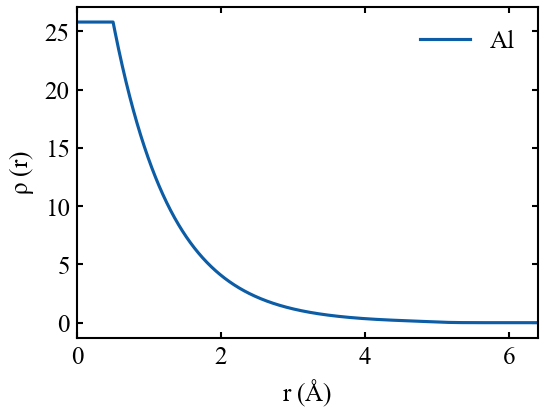

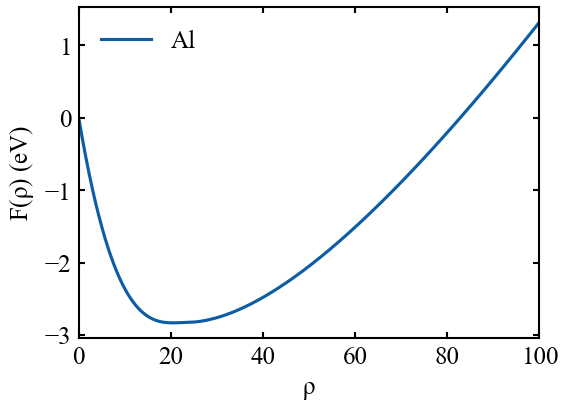

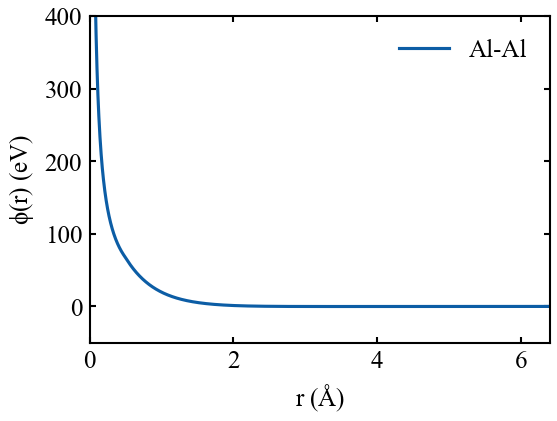

In [69]:
potential.plot()

#### 8.2 使用势函数计算Al的EOS曲线

In [70]:
energy = []
lattice_constant = 4.05
fcc = mp.LatticeMaker(lattice_constant, 'FCC', 1, 1, 1)
fcc.compute()
for scale in np.arange(0.95, 1.06, 0.01):
    print(scale)
    Cal = mp.Calculator(potential, fcc.pos * scale, [1, 1, 1], fcc.box * scale, ['Al'], np.ones(fcc.N, int))
    Cal.compute()
    energy.append([lattice_constant*scale, Cal.energy.mean()])
energy = np.array(energy)

0.95


D:\Anaconda\envs\mda_ovito\lib\site-packages\taichi\lang\expr.py:101: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return Expr(_ti_core.make_const_expr_int(constant_dtype, val))


0.96
0.97
0.98
0.99
1.0
1.01
1.02
1.03
1.04
1.05
1.06


Text(0, 0.5, 'PE (eV/atom)')

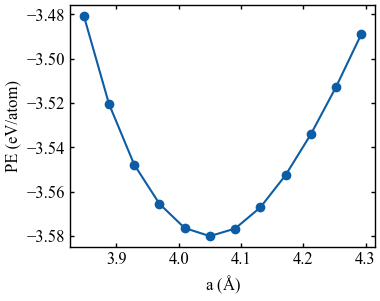

In [71]:
fig = plt.figure(figsize=(mp.cm2inch(10), mp.cm2inch(8)))
plt.plot(energy[:, 0], energy[:, 1], 'o-')
plt.xlabel('a ($\mathregular{\AA}$)')
plt.ylabel('PE (eV/atom)')

## <b> 9. 处理轨迹 </b>

- 读取rdf.0.dump 到rdf.4.dump

In [72]:
MS = mp.MultiSystem([f'traj/rdf.{i}.dump' for i in range(5)])

Reading traj/rdf.4.dump

In [73]:
MS[0]

Filename: traj/rdf.0.dump
Atom Number: 15625
Simulation Box:
[[ 27.4946022   0.          0.       ]
 [  0.         27.4946022   0.       ]
 [  0.          0.         27.4946022]
 [-13.7473011 -13.7473011 -13.7473011]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
   id  type          x         y          z
0   1     0  10.015530 -4.348063  -6.279958
1   2     0  -5.159263 -6.642017   1.142190
2   3     0   0.461460 -6.818775 -12.233191
3   4     0   6.030577  9.578183   4.405061
4   5     0   8.068093 -5.647203   9.575496

- 计算MSD

In [74]:
MS.cal_mean_squared_displacement()

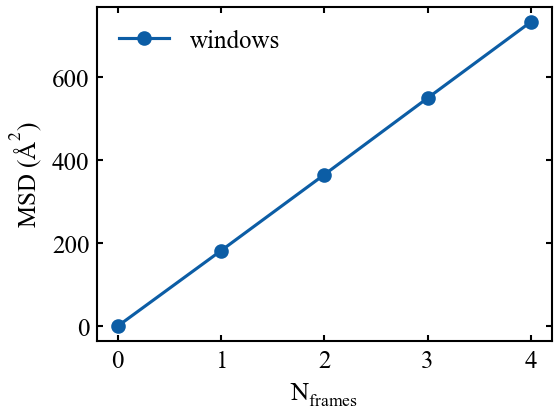

In [75]:
fig, ax = MS.MSD.plot()

- 计算Lindemannindex

In [76]:
MS.cal_lindemann_parameter()

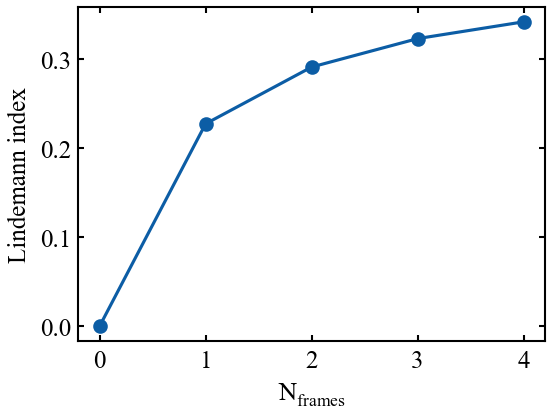

In [77]:
fig, ax = MS.Lindemann.plot()

In [78]:
MS[0]

Filename: traj/rdf.0.dump
Atom Number: 15625
Simulation Box:
[[ 27.4946022   0.          0.       ]
 [  0.         27.4946022   0.       ]
 [  0.          0.         27.4946022]
 [-13.7473011 -13.7473011 -13.7473011]]
TimeStep: 0
Boundary: [1, 1, 1]
Particle Information:
   id  type          x         y          z           msd  lindemann
0   1     0  10.015530 -4.348063  -6.279958  0.000000e+00        0.0
1   2     0  -5.159263 -6.642017   1.142190 -1.136868e-13        0.0
2   3     0   0.461460 -6.818775 -12.233191  5.684342e-14        0.0
3   4     0   6.030577  9.578183   4.405061 -1.136868e-13        0.0
4   5     0   8.068093 -5.647203   9.575496  0.000000e+00        0.0

In [79]:
MS.write_dumps()

Saving traj/rdf.4.dump